In [10]:
import torch
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

import sys
from pathlib import Path


project_root = Path.cwd().parent 
sys.path.append(str(project_root))
sys.path.append("../")


from src.utils import (check_cuda, get_dataset, low_density_anomalies,
                   select_model, setup_experiment)
from src.utils import get_dataset, select_model
from hydra import initialize, compose
from src.shap_explainer import ShapExplainer


2025-01-23 09:36:05.197725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 09:36:05.213077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 09:36:05.217751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 09:36:05.229735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 09:36:06.090086: W tensorflow/comp

In [11]:
def explanation_accuracy(ground_truth, explanation, k="auto"):
    if explanation.shape != ground_truth.shape:
        raise ValueError(
            "The explanation and ground truth must have the same shape."
        )
    if len(explanation.shape) == 1:
        explanation = explanation.reshape(1, -1)
    if len(ground_truth.shape) == 1:
        ground_truth = ground_truth.reshape(1, -1)
    if type(explanation) is torch.Tensor:
        explanation = explanation.cpu().detach().numpy()
    if type(ground_truth) is torch.Tensor:
        ground_truth = ground_truth.cpu().detach().numpy()
    accuracy = []
    for row in range(ground_truth.shape[0]):
        if k == "auto":
            k_ = int(np.sum(ground_truth[row]))
        else:
            k_ = k
        if k_ == 0 or int(np.sum(ground_truth[row])) == 0:
            continue
        sorted_indices = np.argsort(explanation[row])[::-1]
        instance_explanation = np.zeros_like(explanation[row])
        instance_explanation[sorted_indices[:k_]] = 1

        instance_accuracy = (
            np.sum(ground_truth[row] * instance_explanation) / k_
        )
        accuracy.append(instance_accuracy)
    return np.mean(accuracy)


def dcg_score_matrix_p(importance_scores, relevance_matrix, p):
    """
    Compute the DCG scores at a given cutoff rank p.
    """
    importance_scores = np.array(importance_scores)
    relevance_matrix = np.array(relevance_matrix)
    importance_scores = importance_scores.squeeze()
    relevance_matrix = relevance_matrix.squeeze()
    assert (
        importance_scores.shape == relevance_matrix.shape
    ), "importance_scores and relevance_matrix must have the same shape"

    # Sort relevance based on importance scores
    if len(importance_scores.shape) == 1:
        importance_scores = importance_scores.reshape(1, -1)
        relevance_matrix = relevance_matrix.reshape(1, -1)

    sorted_indices = np.argsort(importance_scores, axis=1)[:, ::-1]
    sorted_relevance = np.take_along_axis(
        relevance_matrix, sorted_indices, axis=1
    )

    # Consider only the top p items
    sorted_relevance_p = sorted_relevance[:, :p]
    ranks = np.arange(1, p + 1)  # Ranks from 1 to p

    # Compute DCG scores
    dcg_scores = np.sum(sorted_relevance_p / np.log2(ranks + 1), axis=1)

    return dcg_scores


def idcg_score_matrix_p(relevance_matrix, p):
    """
    Compute the IDCG scores at a given cutoff rank p.
    """
    if len(relevance_matrix.shape) == 1:
        relevance_matrix = relevance_matrix.reshape(1, -1)
    relevance_matrix = np.array(relevance_matrix)
    sorted_relevance = np.sort(relevance_matrix, axis=1)[:, ::-1]

    # Consider only the top p items
    sorted_relevance_p = sorted_relevance[:, :p]
    ranks = np.arange(1, p + 1)  # Ranks from 1 to p

    # Compute IDCG scores
    idcg_scores = np.sum(sorted_relevance_p / np.log2(ranks + 1), axis=1)

    return idcg_scores


def nDCG_(importance_scores, relevance_matrix, p):
    """
    Compute the nDCG scores at a given cutoff rank p.
    """
    dcg_scores_p = dcg_score_matrix_p(importance_scores, relevance_matrix, p)
    idcg_scores_p = idcg_score_matrix_p(relevance_matrix, p)

    # Compute normalized DCG
    ndcg_scores_p = np.zeros_like(dcg_scores_p)
    for i in range(len(dcg_scores_p)):
        if idcg_scores_p[i] == 0:
            ndcg_scores_p[i] = 0
        else:
            ndcg_scores_p[i] = dcg_scores_p[i] / idcg_scores_p[i]

    return ndcg_scores_p


def nDCG_p(importance_scores, relevance_matrix, k= 'auto'):
    nDCG_scores = []
    if len(importance_scores.shape) == 1:
        importance_scores = importance_scores.reshape(1, -1)
    if len(relevance_matrix.shape) == 1:
        relevance_matrix = relevance_matrix.reshape(1, -1)
    for i in range(importance_scores.shape[0]):
        if k == "auto":
            k_ = int(np.sum(relevance_matrix[i]))
        else:
            k_ = k
        if k_ == 0 or int(np.sum(relevance_matrix[i])) == 0:
            continue
        nDCG_scores.append(nDCG_(importance_scores[i], relevance_matrix[i], p=k_))
    return np.array(nDCG_scores)


In [12]:
def load_model_and_dataset_from_path(experiment_path, n_samples=200):
    cfg_experiment_path = Path(f"{experiment_path}/experiment_config.yaml")
    model_path = f"{experiment_path}/model.pth"
        
    with initialize(config_path=str(experiment_path), version_base=None):
        cfg = compose(config_name=cfg_experiment_path.name)
    cfg.dataset.dataset_path = "../" + cfg.dataset.dataset_path
    dataset = get_dataset(cfg)
    X = dataset['X_test']
    y = dataset['y_test']
    explanation = dataset['explanation_test']

    # keep only data with label != 0
    X = X[y != 0]
    explanation = explanation[y != 0]
    y = y[y != 0]

    # Select 200 random instances from the dataset
    random_indices = np.random.choice(len(X), n_samples, replace=False)
    instances = X[random_indices]
    explanations = explanation[random_indices]
    labels = y[random_indices]
    model = select_model(cfg.model, device="cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_model(model_path, X)
    return model, instances, explanations, labels, dataset, cfg

In [27]:
dsil_exp_path = "../results/all_db_all_training/DTEC_DSIL_deterministic_0.5_s0_T400_bins7/A_synthetic_f100_s5000_c40_r0.01_0.01_0.01_0.01_0.01_seed_1"

In [28]:
model, instances, explanations, labels, dataset, cfg = load_model_and_dataset_from_path(dsil_exp_path)


{'Samples': 5000, 'Features': 100, 'Anomalies': 250, 'Anomalies Ratio(%)': 5.0}


/home/elouan/code/code_repo/src/models/dte.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [29]:
X = dataset['X_test']
# Take randomly 10% of the test set randomly
random_indices = np.random.choice(len(X), int(len(X)*0.1), replace=False)
subset_X = X[random_indices]


In [30]:
import time

def ours_mean_explanation_time(model, instances, ground_truth, n_samples=200):
    explanation_times = []
    nDCG_scores = []
    accuracy_scores= []
    for i in tqdm(range(n_samples)):
        instance = instances[i]
        start = time.time()
        explanation = model.instance_explanation(instance, step=50)
        end = time.time()
        explanation_times.append(end-start)
        nDCG = nDCG_p(explanation, ground_truth[i])
        nDCG_scores.append(nDCG)
        accuracy_scores.append(explanation_accuracy(ground_truth[i], explanation))
    return np.mean(explanation_times), np.mean(nDCG_scores), np.mean(accuracy_scores)

In [31]:
ours_mean_explanation_time(model, instances, explanations, n_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

(0.5398874545097351, 0.5708035588536545, 0.5148115615615616)

In [38]:
def shap_mean_explanation_time(model, instances, ground_truth, n_samples=200, r=2):
    explanation_times = []
    nDCG_scores = []
    shap_explainer = ShapExplainer(model, subset_X)
    accuracy_scores= []

    # shap_explainer = ShapExplainer(model, np.zeros((1, instances.shape[1])))
    for i in tqdm(range(n_samples)):
        instance = instances[i]
        start = time.time()
        explanation = shap_explainer.explain_instance(instance, nsamples=int(r* instance.shape[0]))
        end = time.time()
        explanation_times.append(end-start)
        nDCG = nDCG_p(explanation, ground_truth[i])
        nDCG_scores.append(nDCG)
        accuracy_scores.append(explanation_accuracy(ground_truth[i], explanation.squeeze()))

    return np.mean(explanation_times), np.mean(nDCG_scores), np.mean(accuracy_scores)

In [39]:
shap_mean_explanation_time(model, instances, explanations,n_samples=200, r = 1.5)

  0%|          | 0/200 [00:00<?, ?it/s]

(1.8338360822200774, 0.5843692278372412, 0.5145176426426427)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

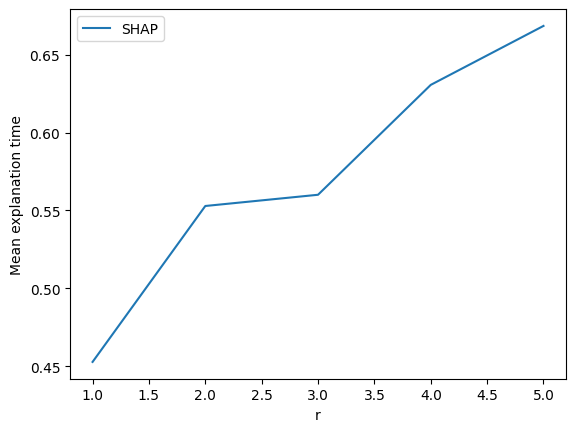

In [19]:
# Compute SHAP mean for different values of r
r_values = [1, 2, 3, 4, 5]
shap_mean_times = []
shap_mean_ndcgs = []
for r in r_values:
    mean_time, mean_ndcg = shap_mean_explanation_time(model, instances, explanations, n_samples=50, r=r)
    shap_mean_times.append(mean_time)
    shap_mean_ndcgs.append(mean_ndcg)

# Plot 
plt.plot(r_values, shap_mean_times, label="SHAP")
plt.xlabel("r")
plt.ylabel("Mean explanation time")
plt.legend()

In [ ]:
score = model.predict_score(dataset["X_test"], device='cuda:0' if torch.cuda.is_available() else 'cpu')
dataset["y_test"][dataset["y_test"] > 0] = 1
metric_df = pd.read_csv(Path(saving_path, "model_metrics.csv"))
force_rerun = cfg.force_rerun
indices = np.arange(len(dataset["y_test"]))
# Suppose we know how much anomaly are in the dataset
y_pred = low_density_anomalies(-score, len(indices[dataset["y_test"] == 1]))
samples_indices = np.arange(len(dataset["X_test"]))[y_pred == 1]
samples = dataset["X_test"][samples_indices]
expected_explanation = dataset["explanation_test"][samples_indices]
labels = dataset["y_test"][samples_indices]

